# Motivación

Ésta libreta tiene como objetivo familiarizarse más con las funcionalidades que ofrece la biblioteca de `DeepXDE`. Para lograr esto, primero intentaremos resolver la ecuación logística:

$\frac{dN}{dt}=rN(1-\frac{N}{K})$

$N(0)=N_0$

Con solución exacta:

$N(t)=N_0\frac{K}{N_0+(K-N_0)e^{- r t}} $

## Solución con Runge-Kutta

In [6]:
from scipy.integrate import odeint
import numpy as np



def log_dif_eq(y:float,x:None,r:float=0.01,k:float=100)->float:
    return r*y*(1-y/k)

def analytic_sol(y0:float,interval:tuple,r:float=0.01,k:float=100)->list:
    x_values = np.linspace(interval[0], interval[1], 1000)
    curve = [  ( x, y0* k / (y0 + (k - y0) * np.exp(- r * x)) ) for x in x_values]
    return curve



def runge_kutta(f,y0:float,interval:tuple,n:int=10)->list:
    x=interval[0]
    h=(interval[1]-interval[0])/n
    y_est=y0
    curve=[]
    for i in range(1,n+1):
        k1=h*f(x=x,y=y_est)
        k2=h*f(x=x+h/2,y=y_est+k1/2)
        k3=h*f(x=x+h/2,y=y_est+k2/2)
        k4=h*f(x=x+h,y=y_est+k3)

        # Add point to curve
        curve.append( ( x, y_est) )

        # Update
        y_est+=(k1+2*k2+2*k3+k4)/6
        x+=h
    return curve



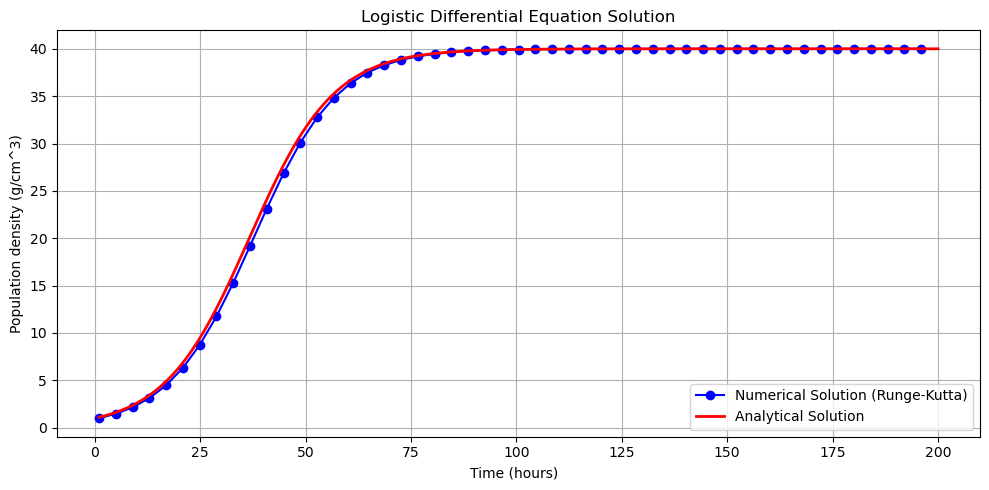

In [7]:
import matplotlib.pyplot as plt

# Diff Eq. Parameters
r=0.1
k=40

# Runge-Kutta Parameters
domain=(1,200)
n_points=50
y_0=1
f=lambda x, y: log_dif_eq(y=y, x=x, r=r, k=k)


numeric_solution=runge_kutta(f=f,y0=y_0,interval=domain,n=n_points)
analytic_solution=analytic_sol(y0=y_0,interval=domain,r=r,k=k)

# Plot

x_numeric, y_numeric = zip(*numeric_solution)
x_analytic, y_analytic = zip(*analytic_solution)

plt.figure(figsize=(10, 5))
plt.plot(x_numeric, y_numeric, label='Numerical Solution (Runge-Kutta)', color='blue', marker='o')
plt.plot(x_analytic, y_analytic, label='Analytical Solution', color='red', linewidth=2)
plt.title("Logistic Differential Equation Solution")
plt.xlabel("Time (hours)  ")
plt.ylabel("Population density (g/cm^3)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##  Direction Field

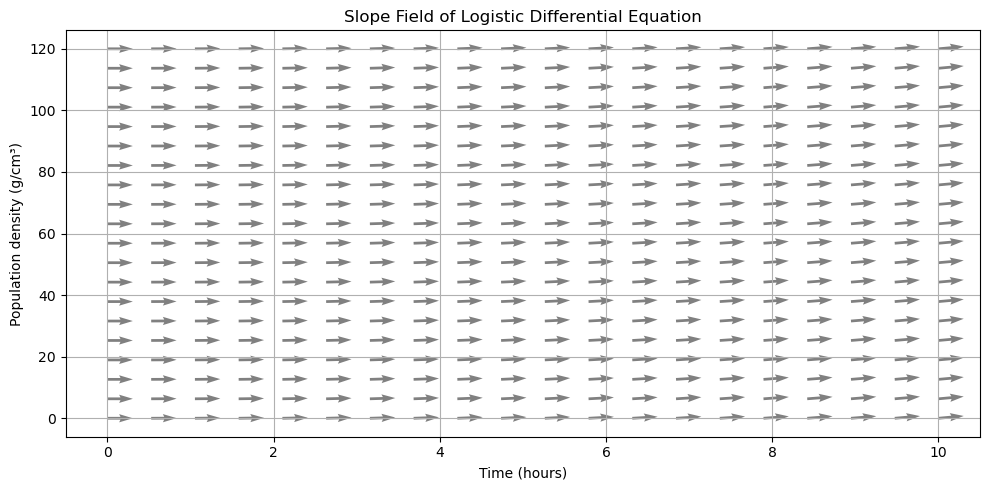

In [8]:
def direction_field(f, x_range: tuple, y_range: tuple, n_spaces: int = 20):
    x_vals = np.linspace(x_range[0], x_range[1], n_spaces)
    y_vals = np.linspace(y_range[0], y_range[1], n_spaces)
    X, Y = np.meshgrid(x_vals, y_vals)

    U = np.ones_like(X)  # dx = 1
    V= np.vectorize(f)(X, Y) # dy/dx = f(y, x), evaluated elementwise <-- Important

    # Normalize the vectors for better visibility
    magnitude = np.sqrt(U**2 + V**2)
    U /= magnitude
    V /= magnitude

    return X, Y, U, V

X, Y, U, V = direction_field(log_dif_eq, x_range=(0, 10), y_range=(0, 120), n_spaces=20)

plt.figure(figsize=(10, 5))
plt.quiver(X, Y, U, V, color='gray')
plt.title("Slope Field of Logistic Differential Equation")
plt.xlabel("Time (hours)")
plt.ylabel("Population density (g/cm³)")
plt.grid(True)
plt.tight_layout()
plt.show()


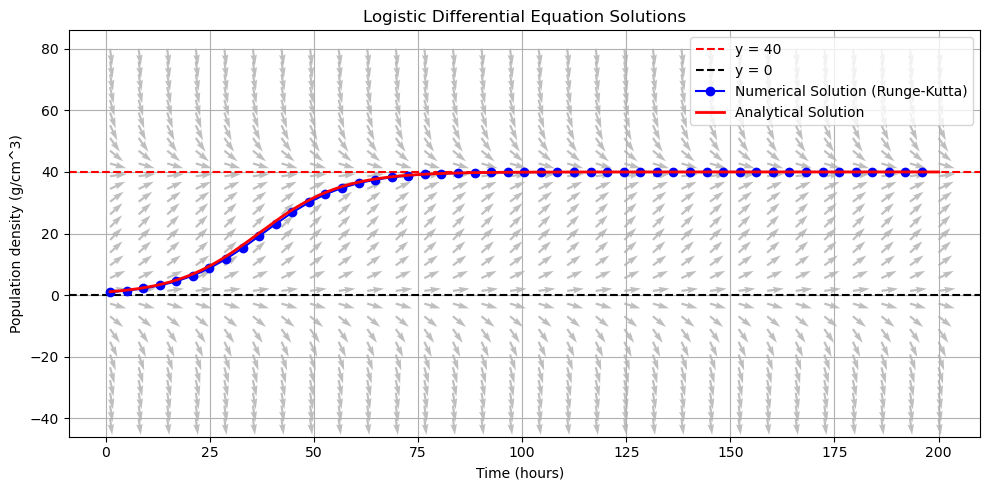

In [9]:
import matplotlib.pyplot as plt

# Diff Eq. Parameters
r=0.1
k=40

# Runge-Kutta Parameters
domain=(1,200)
n_points=50
y_0=1
f=lambda x, y: log_dif_eq(y=y, x=x, r=r, k=k)


numeric_solution= runge_kutta(f=f,y0=y_0,interval=domain,n=n_points)
analytic_solution= analytic_sol(y0=y_0,interval=domain,r=r,k=k)

# Plot

x_numeric, y_numeric = zip(*numeric_solution)
x_analytic, y_analytic = zip(*analytic_solution)
X, Y, U, V = direction_field(f, x_range=domain, y_range=(-k, 2*k), n_spaces=30)


plt.figure(figsize=(10, 5))
plt.axhline(y=k, color='r', linestyle='--', label=f'y = {k}')
plt.axhline(y=0, color='black', linestyle='--', label='y = 0')
plt.plot(x_numeric, y_numeric, label='Numerical Solution (Runge-Kutta)', color='blue', marker='o')
plt.plot(x_analytic, y_analytic, label='Analytical Solution', color='red', linewidth=2)
plt.quiver(X, Y, U, V, color='gray',alpha=0.5)
plt.title("Logistic Differential Equation Solutions")
plt.xlabel("Time (hours)  ")
plt.ylabel("Population density (g/cm^3)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## DeepXDE

In [10]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

T=20
k=3
y_0=k

#dde.backend.backend_name="tensorflow"

ModuleNotFoundError: No module named 'deepxde'

### Condiciones de frontera Dirichlet

In [ ]:
geometry=dde.geometry.Interval(0,100)

def boundary_function(t):
    return y_0

def boundary(x,on_boundary):
    return on_boundary

boundary_conditions=dde.icbc.DirichletBC(geometry,boundary_function,boundary)

### Ecuación Diferencial Ordinaria

In [ ]:
n_train_points=20
n_boundary_points=2

def ode(t,y,T,k):
    dy_dt=dde.grad.jacobian(y,t)
    return dy_dt-T*y*(k-y)

def exact_solution(t,T,k):
    return y_0*(k)/(y_0+(k-y_0)*np.exp(-k*T*t))

data=dde.data.PDE(geometry,ode,boundary_conditions,n_train_points,n_boundary_points,solution=exact_solution,num_tests=100)